In [15]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from functools import reduce
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
%run /Users/Manon/Desktop/data-analysis/functions.py

In [2]:
label = "Plots_rewrite/"
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['font.family'] = 'Comic Sans MS'

In [3]:
df = pd.read_csv("data/rewrite/2024-05-01-10-43_rewrite_1_percent.csv")
df["avg_cos"] = (df.original_to_rewritten_chosen_vector_cos_sim + df.original_to_rewritten_rejected_vector_cos_sim)/2

In [4]:
columns_original = ["original_chosen_last_response_is_helpful",
"original_chosen_last_response_is_harmless",
"original_chosen_last_response_is_coherent",
"original_chosen_last_response_is_eloquent",
"original_chosen_last_response_sentiment",
"original_rejected_last_response_is_helpful",
"original_rejected_last_response_is_harmless",
"original_rejected_last_response_is_coherent",
"original_rejected_last_response_is_eloquent",
"original_rejected_last_response_sentiment"]

columns_rewritten = ["rewritten_chosen_last_response_is_helpful",
"rewritten_chosen_last_response_is_harmless",
"rewritten_chosen_last_response_is_coherent",
"rewritten_chosen_last_response_is_eloquent",
"rewritten_chosen_last_response_sentiment",
"rewritten_rejected_last_response_is_helpful",
"rewritten_rejected_last_response_is_harmless",
"rewritten_rejected_last_response_is_coherent",
"rewritten_rejected_last_response_is_eloquent",
"rewritten_rejected_last_response_sentiment"]

In [5]:
df[['original_agreement_dataset_and_rm_aligned',
       'rewritten_agreement_dataset_and_rm_aligned',
       'original_agreement_dataset_and_rm_control',
       'rewritten_agreement_dataset_and_rm_control']].mean(axis=0)

original_agreement_dataset_and_rm_aligned     0.731965
rewritten_agreement_dataset_and_rm_aligned    0.701493
original_agreement_dataset_and_rm_control     0.567786
rewritten_agreement_dataset_and_rm_control    0.547886
dtype: float64

In [6]:
columns = ['row_id', 'original_chosen_score_rm_aligned',
       'original_rejected_score_rm_aligned',
          'rewritten_chosen_score_rm_aligned',
       'rewritten_rejected_score_rm_aligned',
          'original_to_rewritten_chosen_vector_cos_sim',
       'original_to_rewritten_rejected_vector_cos_sim']

chosen_cols = ['row_id','original_chosen_score_rm_aligned', 'rewritten_chosen_score_rm_aligned', 'original_to_rewritten_chosen_vector_cos_sim']
rejected_cols = ['row_id','original_rejected_score_rm_aligned', 'rewritten_rejected_score_rm_aligned', 'original_to_rewritten_rejected_vector_cos_sim']
duplicated_chosen_cols = df[chosen_cols].copy()
duplicated_rejected_cols = df[rejected_cols].copy()
duplicated_chosen_cols.rename(columns={col: col.replace('chosen_', '') for col in chosen_cols}, inplace=True)
duplicated_rejected_cols.rename(columns={col: col.replace('rejected_', '') for col in rejected_cols}, inplace=True)
duplicated_chosen_cols["preference"] = ['chosen']*len(duplicated_chosen_cols)
duplicated_rejected_cols["preference"] = ['rejected']*len(duplicated_chosen_cols)
new_df = pd.concat([duplicated_chosen_cols, duplicated_rejected_cols], axis=0)
new_df["diff"] = new_df.original_score_rm_aligned - new_df.rewritten_score_rm_aligned
np.corrcoef(new_df.original_score_rm_aligned, new_df.rewritten_score_rm_aligned)

array([[1.        , 0.95810854],
       [0.95810854, 1.        ]])

In [7]:
x1 = list(df.rewritten_chosen_score_rm_aligned)
x2 = list(df.original_chosen_score_rm_aligned)
y1 = list(df.rewritten_rejected_score_rm_aligned)
y2 = list(df.original_rejected_score_rm_aligned)

angles = []
angle_old = []
angle_new = []
angles_rad = []
angle_old_rad = []
angle_new_rad = []
cos = []
cos_old = []
cos_new = []
t = 0
for k in range (len(x1)):
    a, b, e = [x1[k], y1[k]], [x2[k], y2[k]], [-1/np.sqrt(2), -1/np.sqrt(2)]
    angles.append(compute_angle(b, a)[0])
    angle_old.append(compute_angle(e, b)[0])
    angle_new.append(compute_angle(e, a)[0])
    cos_old.append(compute_cos(b, [1/np.sqrt(2), -1/np.sqrt(2)]))
    cos_new.append(compute_cos(a, [1/np.sqrt(2), -1/np.sqrt(2)]))

df["angles_uv"] = angles
df["angles_u"] = angle_old
df["angles_v"] = angle_new
df["cos_u"] = cos_old
df["cos_v"] = cos_new

/Users/Manon/Desktop/data-analysis/functions.py:106: RuntimeWarning: invalid value encountered in arccos
  signed_angle_rad = np.arccos(cos_angle)


# Angular Shift and Direction in the Alignment Dataset

[0.03274774 3.036648   0.61660453 ... 1.48178598 0.22124889 3.02801722] 16
[-9.85158642e-04 -2.97450415e+00  5.98379689e-01 ...  1.62367915e+00
  1.30989242e-01  2.95796570e+00] 16
[-0.0337329   0.27203316 -0.01822484 ...  0.14189317 -0.09025965
 -0.07005152] 16


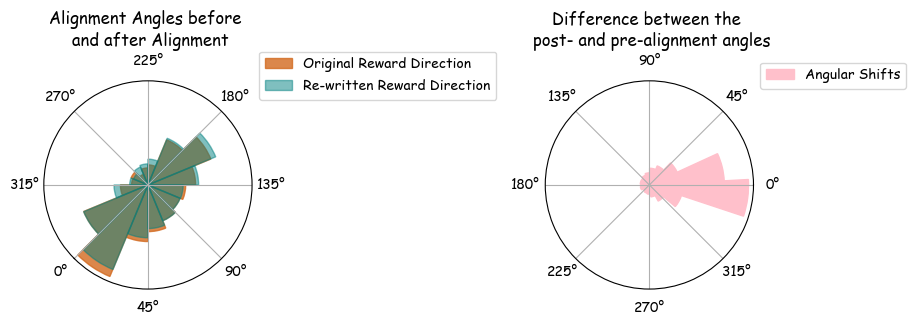

In [10]:
angles0 = np.array([math.radians(k) for k in angle_old])
angles0 = angles0[~np.isnan(angles0)]

angles1 = np.array([math.radians(k) for k in angle_new])
angles1 = angles1[~np.isnan(angles1)]

anglesuv = np.array([math.radians(k) for k in angles])
anglesuv = anglesuv[~np.isnan(anglesuv)]

fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(8,4))

line1 = circular_hist(ax[0], angles0, 0.8, "Original Reward Direction", offset = 5*np.pi/4, color = "chocolate")[2]
line2 = circular_hist(ax[0], angles1, 0.5, "Re-written Reward Direction", offset = 5*np.pi/4, color = "teal")[2]
circular_hist(ax[1], anglesuv, 1, "Angular Shifts", offset = 0, color = "pink")

ax[0].legend(handles=[line1, line2], bbox_to_anchor=(1,1.025), loc="center left")
ax[0].set_title("Alignment Angles before \n and after Alignment")
ax[1].set_title("Difference between the \n post- and pre-alignment angles")
plt.tight_layout()
plt.legend()
plt.legend(bbox_to_anchor=(1,1.025), loc="center left")
plt.savefig(f'{label}rewriting-angle-round.png', bbox_inches='tight', transparent=True) 

In [11]:
path3 = "data/taxonomy/2024-05-09-14-33_full_dataset.csv"
path2 = 'data/compare/2024-05-05-22-08-openassistant-reward-model-deberta-v3-large-v2.csv'
pathn_1 = 'data/compare/2024-05-05-22-08-openassistant-reward-model-deberta-v3-large.csv'

df_n_1 = pd.read_csv(pathn_1)
df_n = pd.read_csv(path2)

df_rewards = df_n.loc[df_n.row_id.isin(df.row_id)]
df_rewards_n_1 = df_n_1.loc[df_n_1.row_id.isin(df.row_id)]


In [13]:
cat_ = []
for i in list(df_rewards.row_id):
    old, new = df_rewards_n_1.loc[df_rewards.row_id == i].agreement.values, df_rewards.loc[df_rewards.row_id == i].agreement.values
    if old == new == True:
        cat_.append("stayed aligned")
    elif old == new == False:
        cat_.append("resists alignment")
    elif old ==  True:
        cat_.append("reversed alignment")
    else:
        cat_.append("got aligned")
df["align_shift"] = cat_

# On the impact of cosine similarity on rewards

/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_19567/950432094.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df, x="avg_cos", y="angles_uv", shade=True)


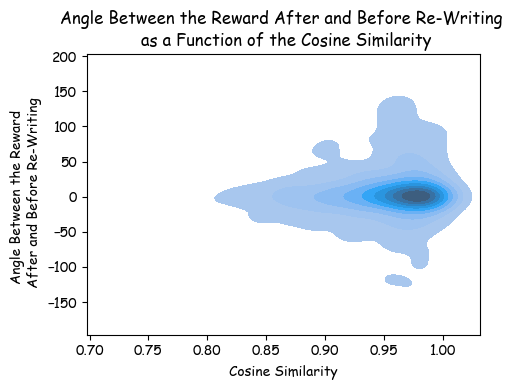

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.kdeplot(data = df, x="avg_cos", y="angles_uv", shade=True)
plt.title("Angle Between the Reward After and Before Re-Writing \n as a Function of the Cosine Similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Angle Between the Reward \n After and Before Re-Writing")
plt.tight_layout()
plt.savefig(f'{label}cosine.png', bbox_inches='tight', transparent=True, dpi=1200) 

# On the impact of rewriting on the features

In [17]:
columns_original_chosen = ["original_chosen_last_response_is_helpful",
"original_chosen_last_response_is_harmless",
"original_chosen_last_response_is_coherent",
"original_chosen_last_response_is_eloquent",
"original_chosen_last_response_sentiment"]


columns_original_rejected = ["original_rejected_last_response_is_helpful",
"original_rejected_last_response_is_harmless",
"original_rejected_last_response_is_coherent",
"original_rejected_last_response_is_eloquent",
"original_rejected_last_response_sentiment"]

columns_rewritten_chosen = ["rewritten_chosen_last_response_is_helpful",
"rewritten_chosen_last_response_is_harmless",
"rewritten_chosen_last_response_is_coherent",
"rewritten_chosen_last_response_is_eloquent",
"rewritten_chosen_last_response_sentiment"]


columns_rewritten_rejected = ["rewritten_rejected_last_response_is_helpful",
"rewritten_rejected_last_response_is_harmless",
"rewritten_rejected_last_response_is_coherent",
"rewritten_rejected_last_response_is_eloquent",
"rewritten_rejected_last_response_sentiment"]

all = []
for o_c, o_r, r_c, r_r in zip(columns_original_chosen, columns_original_rejected, columns_rewritten_chosen, columns_rewritten_rejected):
    print(o_c)
    if "sentiment" in o_c:
        l1 = list(df[o_c].replace({"negative": -1, "neutral": 0, "positive":1}) - df[r_c].replace({"negative": -1, "neutral": 0, "positive":1}))
        l2 = list(df[o_r].replace({"negative": -1, "neutral": 0, "positive":1}) - df[r_r].replace({"negative": -1, "neutral": 0, "positive":1}))
        l1.extend(l2)
        all.append(l1)
    else:
        l1 = list(df[o_c].astype(int) - df[r_c].astype(int))
        l2 = list(df[o_r].astype(int) - df[r_r].astype(int))
        l1.extend(l2)
        all.append(l1)

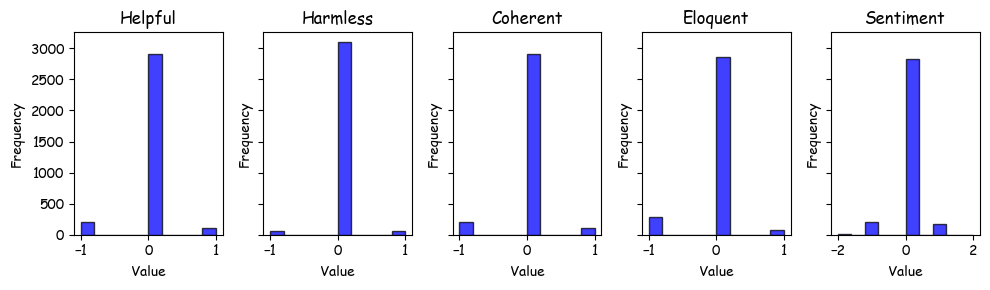

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True)
titles = ["Helpful", "Harmless", "Coherent", "Eloquent", "Sentiment"]
for i, ax in enumerate(axes):
    ax.hist(all[i], alpha=0.75, color='blue', edgecolor='black')
    ax.set_title(titles[i])
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(f'{label}freq_shift.png', bbox_inches='tight', transparent=True, dpi=1200) 


In [20]:
for k in all:
    c = Counter(k)
    total = sum(c.values())
    percent = {key: value/total for key, value in c.items()}
    print(percent)

{0: 0.9045398009950248, 1: 0.033893034825870645, -1: 0.061567164179104475}
{0: 0.9645522388059702, 1: 0.017723880597014924, -1: 0.017723880597014924}
{0: 0.9029850746268657, 1: 0.03451492537313433, -1: 0.0625}
{0: 0.8877487562189055, -1: 0.09017412935323384, 1: 0.022077114427860697}
{0: 0.8784203980099502, 1: 0.051305970149253734, -1: 0.06560945273631841, -2: 0.0037313432835820895, 2: 0.0009328358208955224}


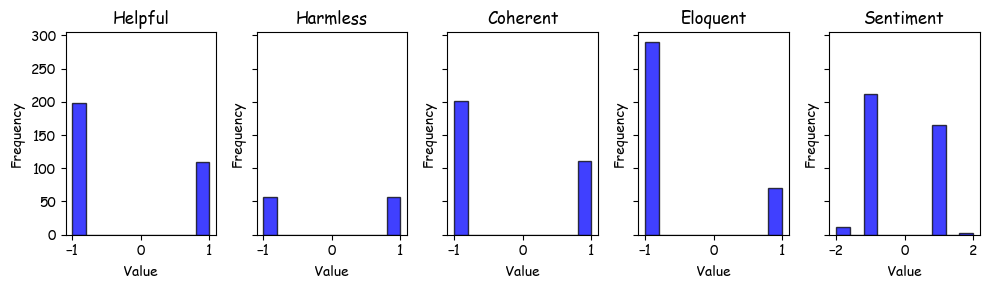

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True)
titles = ["Helpful", "Harmless", "Coherent", "Eloquent", "Sentiment"]
for i, ax in enumerate(axes):
    ax.hist([x for x in all[i] if x != 0], alpha=0.75, color='blue', edgecolor='black')
    ax.set_title(titles[i])
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(f'{label}fre_shift2.png', bbox_inches='tight', transparent=True, dpi=1200) 


In [31]:
df["flip_helpful_chosen"] = df["original_chosen_last_response_is_helpful"].astype(int) - df["rewritten_chosen_last_response_is_helpful"].astype(int) 
df["flip_helpful_rejected"] = df["original_rejected_last_response_is_helpful"].astype(int) - df["rewritten_rejected_last_response_is_helpful"].astype(int) 
df["flip_harmless_chosen"] = df["original_chosen_last_response_is_harmless"].astype(int) - df["rewritten_chosen_last_response_is_harmless"].astype(int) 
df["flip_harmless_rejected"] = df["original_rejected_last_response_is_harmless"].astype(int) - df["rewritten_rejected_last_response_is_harmless"].astype(int) 
df["flip_coherent_chosen"] = df["original_chosen_last_response_is_coherent"].astype(int) - df["rewritten_chosen_last_response_is_coherent"].astype(int) 
df["flip_coherent_rejected"] = df["original_rejected_last_response_is_coherent"].astype(int) - df["rewritten_rejected_last_response_is_coherent"].astype(int) 
df["flip_elequent_chosen"] = df["original_chosen_last_response_is_eloquent"].astype(int) - df["rewritten_chosen_last_response_is_eloquent"].astype(int) 
df["flip_elequent_rejected"] = df["original_rejected_last_response_is_eloquent"].astype(int) - df["rewritten_rejected_last_response_is_eloquent"].astype(int) 
df["flip_sentiment_chosen"] = df["original_chosen_last_response_sentiment"].replace({"negative": -1, "neutral": 0, "positive":1}) - df["rewritten_chosen_last_response_sentiment"].replace({"negative": -1, "neutral": 0, "positive":1})
df["flip_sentiment_rejected"] = df["original_rejected_last_response_sentiment"].replace({"negative": -1, "neutral": 0, "positive":1}) - df["rewritten_rejected_last_response_sentiment"].replace({"negative": -1, "neutral": 0, "positive":1})


print(df.groupby(["flip_helpful_chosen"]).avg_cos.agg(["mean", "std"]))
print(df.groupby(["flip_helpful_rejected"]).avg_cos.agg(["mean", "std"]))
print(df.groupby(["flip_harmless_chosen"]).avg_cos.agg(["mean", "std"]))
print(df.groupby(["flip_harmless_rejected"]).avg_cos.agg(["mean", "std"]))
print(df.groupby(["flip_coherent_chosen"]).avg_cos.agg(["mean", "std"]))
print(df.groupby(["flip_coherent_rejected"]).avg_cos.agg(["mean", "std"]))
print(df.groupby(["flip_elequent_chosen"]).avg_cos.agg(["mean", "std"]))
print(df.groupby(["flip_elequent_rejected"]).avg_cos.agg(["mean", "std"]))
print(df.groupby(["flip_sentiment_chosen"]).avg_cos.agg(["mean", "std"]))
print(df.groupby(["flip_sentiment_rejected"]).avg_cos.agg(["mean", "std"]))

                         mean       std
flip_helpful_chosen                    
-1                   0.939571  0.044931
 0                   0.959355  0.034549
 1                   0.939500  0.049872
                           mean       std
flip_helpful_rejected                    
-1                     0.944357  0.038497
 0                     0.959003  0.035162
 1                     0.946706  0.049332
                          mean       std
flip_harmless_chosen                    
-1                    0.937372  0.034409
 0                    0.958043  0.036101
 1                    0.946048  0.039112
                            mean       std
flip_harmless_rejected                    
-1                      0.937042  0.043644
 0                      0.958214  0.035922
 1                      0.951081  0.034569
                          mean       std
flip_coherent_chosen                    
-1                    0.946599  0.041439
 0                    0.958675  0.035550
 1    

/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_19567/3990464983.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["flip_sentiment_chosen"] = df["original_chosen_last_response_sentiment"].replace({"negative": -1, "neutral": 0, "positive":1}) - df["rewritten_chosen_last_response_sentiment"].replace({"negative": -1, "neutral": 0, "positive":1})
/var/folders/_b/z_0lh8px6q97dgh74dkw4w7r0000gn/T/ipykernel_19567/3990464983.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["flip_sentiment_rejected"] = df["original_r

In [33]:
print(df.groupby(["flip_helpful_chosen"]).original_agreement_dataset_and_rm_aligned.mean())
print(df.groupby(["flip_helpful_rejected"]).original_agreement_dataset_and_rm_aligned.mean())
print(df.groupby(["flip_harmless_chosen"]).original_agreement_dataset_and_rm_aligned.mean())
print(df.groupby(["flip_harmless_rejected"]).original_agreement_dataset_and_rm_aligned.mean())
print(df.groupby(["flip_coherent_chosen"]).original_agreement_dataset_and_rm_aligned.mean())
print(df.groupby(["flip_coherent_rejected"]).original_agreement_dataset_and_rm_aligned.mean())
print(df.groupby(["flip_elequent_chosen"]).original_agreement_dataset_and_rm_aligned.mean())
print(df.groupby(["flip_elequent_rejected"]).original_agreement_dataset_and_rm_aligned.mean())
print(df.groupby(["flip_sentiment_chosen"]).original_agreement_dataset_and_rm_aligned.mean())
print(df.groupby(["flip_sentiment_rejected"]).original_agreement_dataset_and_rm_aligned.mean())

df["became_misaligned"] = ((df['original_agreement_dataset_and_rm_aligned'] == True) & (df['rewritten_agreement_dataset_and_rm_aligned'] == False)).astype(int)
df["became_aligned"] = ((df['original_agreement_dataset_and_rm_aligned'] == False) & (df['rewritten_agreement_dataset_and_rm_aligned'] == True)).astype(int)
df["stayed_same"] = (df['original_agreement_dataset_and_rm_aligned'] == df['rewritten_agreement_dataset_and_rm_aligned']).astype(int)

print(df.groupby(["flip_helpful_chosen"]).became_misaligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_helpful_rejected"]).became_misaligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_harmless_chosen"]).became_misaligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_harmless_rejected"]).became_misaligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_coherent_chosen"]).became_misaligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_coherent_rejected"]).became_misaligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_elequent_chosen"]).became_misaligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_elequent_rejected"]).became_misaligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_sentiment_chosen"]).became_misaligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_sentiment_rejected"]).became_misaligned.agg(["mean", "std", 'count']))


flip_helpful_chosen
-1    0.684783
 0    0.736519
 1    0.686275
Name: original_agreement_dataset_and_rm_aligned, dtype: float64
flip_helpful_rejected
-1    0.811321
 0    0.725069
 1    0.758621
Name: original_agreement_dataset_and_rm_aligned, dtype: float64
flip_harmless_chosen
-1    0.619048
 0    0.732566
 1    0.791667
Name: original_agreement_dataset_and_rm_aligned, dtype: float64
flip_harmless_rejected
-1    0.694444
 0    0.730344
 1    0.848485
Name: original_agreement_dataset_and_rm_aligned, dtype: float64
flip_coherent_chosen
-1    0.670103
 0    0.737311
 1    0.698113
Name: original_agreement_dataset_and_rm_aligned, dtype: float64
flip_coherent_rejected
-1    0.778846
 0    0.726141
 1    0.793103
Name: original_agreement_dataset_and_rm_aligned, dtype: float64
flip_elequent_chosen
-1    0.600000
 0    0.743466
 1    0.705882
Name: original_agreement_dataset_and_rm_aligned, dtype: float64
flip_elequent_rejected
-1    0.800000
 0    0.720914
 1    0.837838
Name: original_agr

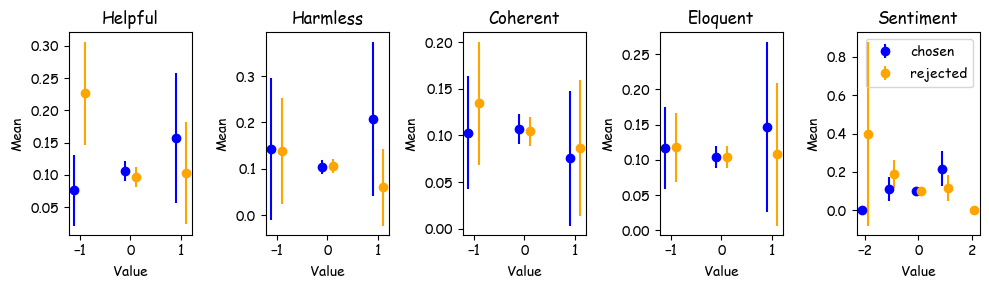

In [32]:
# Gpt was used to generate this data format form theestimate obtained in the previous cells

data = {
    'helpful': {
        'chosen': pd.DataFrame({
            'mean': [0.076087, 0.105802, 0.156863],
            'std': [0.266590, 0.307689, 0.367290],
            'count': [92, 1465, 51]
        }, index=[-1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.226415, 0.096953, 0.103448],
            'std': [0.420499, 0.295996, 0.307203],
            'count': [106, 1444, 58]
        }, index=[-1, 0, 1])
    },
    'harmless': {
        'chosen': pd.DataFrame({
            'mean': [0.142857, 0.103647, 0.208333],
            'std': [0.358569, 0.304899, 0.414851],
            'count': [21, 1563, 24]
        }, index=[-1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.138889, 0.105913, 0.060606],
            'std': [0.350736, 0.307826, 0.242306],
            'count': [36, 1539, 33]
        }, index=[-1, 0, 1])
    },
    'coherent': {
        'chosen': pd.DataFrame({
            'mean': [0.103093, 0.106996, 0.075472],
            'std': [0.305660, 0.309214, 0.266679],
            'count': [97, 1458, 53]
        }, index=[-1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.134615, 0.104426, 0.086207],
            'std': [0.342965, 0.305918, 0.283121],
            'count': [104, 1446, 58]
        }, index=[-1, 0, 1])
    },
    'eloquent': {
        'chosen': pd.DataFrame({
            'mean': [0.116667, 0.103851, 0.147059],
            'std': [0.322369, 0.305173, 0.359491],
            'count': [120, 1454, 34]
        }, index=[-1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.117647, 0.104211, 0.108108],
            'std': [0.323142, 0.305644, 0.314800],
            'count': [170, 1401, 37]
        }, index=[-1, 0, 1])
    },
    'sentiment': {
        'chosen': pd.DataFrame({
            'mean': [0.000000, 0.111111, 0.099789, 0.215190],
            'std': [0.000000, 0.315869, 0.299824, 0.413580],
            'count': [7, 99, 1423, 79]
        }, index=[-2, -1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.400000, 0.187500, 0.097718, 0.116279, 0.000000],
            'std': [0.547723, 0.392067, 0.297038, 0.322439, 0.000000],
            'count': [5, 112, 1402, 86, 3]
        }, index=[-2, -1, 0, 1, 2])
    }
}

def confidence_interval(mean, std, count):
    margin_of_error = 1.96 * (std / np.sqrt(count))
    return mean - margin_of_error, mean + margin_of_error

fig, axes = plt.subplots(1, 5, figsize=(10,3))

for ax, (category, datasets) in zip(axes, data.items()):
    for label, dff in datasets.items():
        color = 'blue' if label == 'chosen' else 'orange'
        x_shift = -0.1 if label == 'chosen' else 0.1
        means = dff['mean']
        cis = [confidence_interval(mean, std, count) for mean, std, count in zip(dff['mean'], dff['std'], dff['count'])]
        lower_bounds, upper_bounds = zip(*cis)
        
        ax.errorbar(dff.index + x_shift, means, yerr=[np.array(means) - np.array(lower_bounds), np.array(upper_bounds) - np.array(means)], fmt='o', color=color, label=label)
    
    ax.set_title(category.capitalize())
    ax.set_xlabel('Value')
    ax.set_ylabel('Mean')
axes[-1].legend()

plt.tight_layout()
label = "Plots_rewrite/"
plt.savefig(f'{label}negative_score.png', bbox_inches='tight', transparent=True, dpi=1200) 


In [107]:
print(df.groupby(["flip_helpful_chosen"]).became_aligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_helpful_rejected"]).became_aligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_harmless_chosen"]).became_aligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_harmless_rejected"]).became_aligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_coherent_chosen"]).became_aligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_coherent_rejected"]).became_aligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_elequent_chosen"]).became_aligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_elequent_rejected"]).became_aligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_sentiment_chosen"]).became_aligned.agg(["mean", "std", 'count']))
print(df.groupby(["flip_sentiment_rejected"]).became_aligned.agg(["mean", "std", 'count']))

                         mean       std  count
flip_helpful_chosen                           
-1                   0.119565  0.326230     92
 0                   0.073720  0.261404   1465
 1                   0.039216  0.196039     51
                           mean       std  count
flip_helpful_rejected                           
-1                     0.047170  0.213009    106
 0                     0.078255  0.268665   1444
 1                     0.051724  0.223404     58
                          mean       std  count
flip_harmless_chosen                           
-1                    0.047619  0.218218     21
 0                    0.076775  0.266320   1563
 1                    0.000000  0.000000     24
                            mean       std  count
flip_harmless_rejected                           
-1                      0.027778  0.166667     36
 0                      0.077323  0.267190   1539
 1                      0.030303  0.174078     33
                          mean

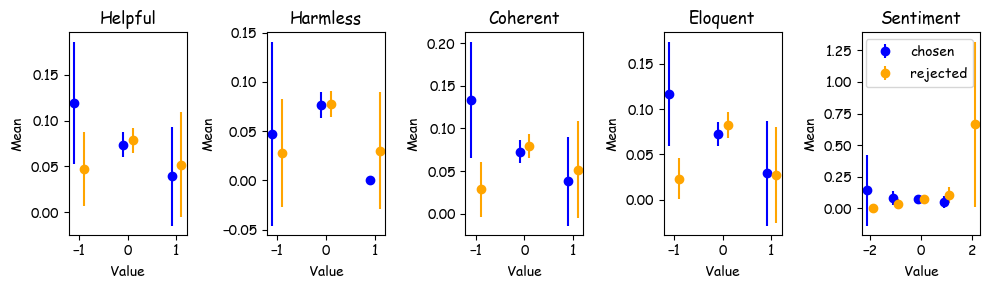

In [34]:
data = {
    'helpful': {
        'chosen': pd.DataFrame({
            'mean': [0.119565, 0.073720, 0.039216],
            'std': [0.326230, 0.261404, 0.196039],
            'count': [92, 1465, 51]
        }, index=[-1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.047170, 0.078255, 0.051724],
            'std': [0.213009, 0.268665, 0.223404],
            'count': [106, 1444, 58]
        }, index=[-1, 0, 1])
    },
    'harmless': {
        'chosen': pd.DataFrame({
            'mean': [0.047619, 0.076775, 0.000000],
            'std': [0.218218, 0.266320, 0.000000],
            'count': [21, 1563, 24]
        }, index=[-1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.027778, 0.077323, 0.030303],
            'std': [0.166667, 0.267190, 0.174078],
            'count': [36, 1539, 33]
        }, index=[-1, 0, 1])
    },
    'coherent': {
        'chosen': pd.DataFrame({
            'mean': [0.134021, 0.072702, 0.037736],
            'std': [0.342444, 0.259736, 0.192380],
            'count': [97, 1458, 53]
        }, index=[-1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.028846, 0.079530, 0.051724],
            'std': [0.168185, 0.270657, 0.223404],
            'count': [104, 1446, 58]
        }, index=[-1, 0, 1])
    },
    'eloquent': {
        'chosen': pd.DataFrame({
            'mean': [0.116667, 0.072902, 0.029412],
            'std': [0.322369, 0.260066, 0.171499],
            'count': [120, 1454, 34]
        }, index=[-1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.023529, 0.082798, 0.027027],
            'std': [0.152025, 0.275675, 0.164399],
            'count': [170, 1401, 37]
        }, index=[-1, 0, 1])
    },
    'sentiment': {
        'chosen': pd.DataFrame({
            'mean': [0.142857, 0.080808, 0.075896, 0.050633],
            'std': [0.377964, 0.273927, 0.264925, 0.220648],
            'count': [7, 99, 1423, 79]
        }, index=[-2, -1, 0, 1]),
        'rejected': pd.DataFrame({
            'mean': [0.000000, 0.035714, 0.075606, 0.104651, 0.666667],
            'std': [0.000000, 0.186411, 0.264461, 0.307899, 0.577350],
            'count': [5, 112, 1402, 86, 3]
        }, index=[-2, -1, 0, 1, 2])
    }
}

# Function to calculate confidence intervals
def confidence_interval(mean, std, count):
    margin_of_error = 1.96 * (std / np.sqrt(count))
    return mean - margin_of_error, mean + margin_of_error

# Remove sharey=True to allow each subplot to have its own scale
fig, axes = plt.subplots(1, 5, figsize=(10,3))

# Adjust the x-coordinates for chosen and rejected estimates
for ax, (category, datasets) in zip(axes, data.items()):
    for label, dff in datasets.items():
        color = 'blue' if label == 'chosen' else 'orange'
        x_shift = -0.1 if label == 'chosen' else 0.1
        means = dff['mean']
        cis = [confidence_interval(mean, std, count) for mean, std, count in zip(dff['mean'], dff['std'], dff['count'])]
        lower_bounds, upper_bounds = zip(*cis)
        
        ax.errorbar(dff.index + x_shift, means, yerr=[np.array(means) - np.array(lower_bounds), np.array(upper_bounds) - np.array(means)], fmt='o', color=color, label=label)
    
    ax.set_title(category.capitalize())
    ax.set_xlabel('Value')
    ax.set_ylabel('Mean')
axes[-1].legend()
label = "Plots_rewrite/"

plt.tight_layout()
plt.savefig(f'{label}positive_score.png', bbox_inches='tight', transparent=True, dpi=1200) 
